# Matrix multiplication from foundations 

In [ ]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil
import matplotlib as mpl, matplotlib.pyplot as plt
import torch

In [ ]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

## Get data

In [ ]:
MNIST_URL = 'https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=True'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

In [ ]:
#! rm -rf {path_data}

In [ ]:
from urllib.request import urlretrieve

In [ ]:
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [ ]:
!ls -l data

total 16653
-rw-r--r-- 1 root root 17051982 May 22 19:48 mnist.pkl.gz


In terminal gz files can be extracted by using `gunzip mnist.pkl.gz`. We can check the encoding of the file using command line `file -i filename`. This will show us that the `pkl` file charset is binary.

In [ ]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

Take the first image 

In [ ]:
lst1 = list(x_train[0])
vals = lst1[200:210]
vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125]

In [ ]:
def chunks(x, sz):
    for i in range(0, len(x), sz): yield x[i:i+sz]

In [ ]:
list(chunks(vals, 3))

[[0.0, 0.0, 0.0],
 [0.19140625, 0.9296875, 0.98828125],
 [0.98828125, 0.98828125, 0.98828125],
 [0.98828125]]

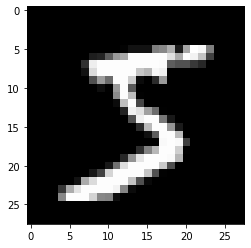

In [ ]:
mpl.rcParams['image.cmap']='gray'
plt.imshow(list(chunks(lst1,28)));

In [ ]:
from itertools import islice

In [ ]:
it = iter(vals)

In [ ]:
list(islice(it, 5))

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

In [ ]:
it = iter(lst1)
img = list(iter(lambda: list(islice(it, 28)), []))

<matplotlib.image.AxesImage>

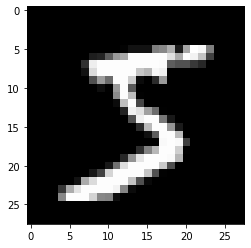

In [ ]:
plt.imshow(img)

Example with iter and islice, which takes an iterator an yields `stop` values starting from (skipping to) `start`, skipping each `step` indices between calls

In [ ]:
??islice

Init signature: islice(self, /, *args, **kwargs)
Docstring:     
islice(iterable, stop) --> islice object
islice(iterable, start, stop[, step]) --> islice object

Return an iterator whose next() method returns selected values from an
iterable.  If start is specified, will skip all preceding elements;
otherwise, start defaults to zero.  Step defaults to one.  If
specified as another value, step determines how many values are
skipped between successive calls.  Works like a slice() on a list
but returns an iterator.
Type:           type
Subclasses:     


In [ ]:
tst = [i for i in range(100)]
tst_iter = iter(tst)

In [ ]:
for _ in range(5):
    print(list(islice(tst_iter,5)))

[0, 1, 2, 3, 4]
[5, 6, 7, 8, 9]
[10, 11, 12, 13, 14]
[15, 16, 17, 18, 19]
[20, 21, 22, 23, 24]


## Matrix and tensor

In [ ]:
img[20][15]

0.98828125

In [ ]:
class Matrix():
    def __init__(self, xs): self.xs = xs
    def __getitem__(self, idxs): return self.xs[idxs[0]][idxs[1]]

In [ ]:
m = Matrix(img)
m[20,15]

0.98828125

In [ ]:
import torch
from torch import tensor

To convert all of the lists to tensors, we can use `map` that takes function and applies it to iterables

In [ ]:
x_train, y_train, x_valid, y_valid = map(tensor,(x_train, y_train, x_valid, y_valid))

In [ ]:
x_train.shape

torch.Size([50000, 784])

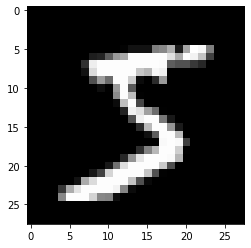

In [ ]:
imgs = x_train.reshape(-1, 28, 28)
plt.imshow(imgs[0]);

## Matrix multiplicaton

In [ ]:
torch.manual_seed(1)
weights = torch.randn(784, 10) # 10 outputs
bias = torch.zeros(1, 10)

In [ ]:
m1 = x_valid[:5] # take a minibatch
m2 = weights
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [ ]:
ar, ac = m1.shape # n_rows * n_cols
br, bc = m2.shape
(ar,ac),(br,bc)

((5, 784), (784, 10))

Create variable to store intermediary result.

In [ ]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 10])

Consider first matrix multiplication with three loops.

In [ ]:
for i in range(ar): # 5 rows
    for j in range(bc): # 10 columns
        for k in range(ac): # 784 entries
            t1[i,j] += m1[i,k] * m2[k,j]

A very useful comand is to set torch printing options in order to use more than 80 cols. It is useful to include it by default on top of the notebook.

In [ ]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

In [ ]:
t1

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

Now let's convert cells above to a function. A useful trick it to copy those cell (press `C` and `V` in M mode) and then select all the cells and press `Control + M`

In [ ]:
def matmul(m1, m2):
    
    # set rows and cols
    (ar,ac), (br,bc) = m1.shape, m2. shape
    
    # prepare output
    t = torch.zeros(ar, bc)

    for i in range(ar): # 5 rows
        for j in range(bc): # 10 columns
            for k in range(ac): # 784 entries
                t[i,j] += m1[i,k] * m2[k,j]
    return t

In [ ]:
matmul(m1, m2)

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

We can check, how long does it take to run a function by using magic function `%timeit`

In [ ]:
%timeit -n 5 matmul(m1, m2)

776 ms ± 30.2 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


So this takes almost half a second to run, which is way too much and will not allow us to use matmul for large datasets (here we are using just a batch of 5 images)

## Numba

One possible way to speed things up it to use numba. We will use it to speed up the most inner loop (which is the largest one as it is 784 items long). Numba works with numpy, so we import numpy array.

In [ ]:
from numba import njit
from numpy import array

In [ ]:
@njit
def dot(a, b):
    res = 0.0
    for i in range(len(a)): res += a[i] * b[i]
    return res

In [ ]:
def matmul(m1, m2):
    
    # set rows and cols
    (ar,ac), (br,bc) = m1.shape, m2. shape
    
    # prepare output
    t = torch.zeros(ar, bc)

    for i in range(ar): # 5 rows
        for j in range(bc): # 10 columns
            t[i,j] = dot(m1[i, :], m2[:,j]) # 784 entries
    return t

In [ ]:
m1a, m2a = m1.numpy(), m2.numpy()

In [ ]:
matmul(m1a, m2a)

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [ ]:
from fastcore.test import *

In [ ]:
test_close(t1, matmul(m1a, m2a))

In [ ]:
%timeit -n 50 matmul(m1a, m2a)

266 µs ± 6.56 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


We managed to speed up one loop and our results is more than 550 times times faster!

## Elementwise operations

In [ ]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a, b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [ ]:
a < b

tensor([False,  True,  True])

In [ ]:
(a < b).float().mean()

tensor(0.67)

In [ ]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Frobenius norm: $\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$

In [ ]:
frob_n = (m*m).sum().sqrt()
frob_n

tensor(16.88)

Now we rewrite our matrix multiplication function using broadcasting to get rid of one loop.

In [ ]:
def matmul(m1, m2):
    
    # set rows and cols
    (ar,ac), (br,bc) = m1.shape, m2. shape
    
    # prepare output
    t = torch.zeros(ar, bc)

    for i in range(ar): # 5 rows
        for j in range(bc): # 10 columns
            t[i,j] = (m1[i, :] * m2[:,j]).sum() # 784 entries
    return t

In [ ]:
test_close(t1, matmul(m1, m2))

In [ ]:
%timeit -n 50 matmul(m1, m2)

687 µs ± 27.2 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


Slower than Numba implementation but still much faster than the initial version. Basically we have recreated above the `torch.dot`. We can use it below.

In [ ]:
def matmul(m1, m2):
    
    # set rows and cols
    (ar,ac), (br,bc) = m1.shape, m2. shape
    
    # prepare output
    t = torch.zeros(ar, bc)

    for i in range(ar): # 5 rows
        for j in range(bc): # 10 columns
            t[i,j] = torch.dot(m1[i,:], m2[:,j]) # 784 entries
    return t

In [ ]:
test_close(t1, matmul(m1, m2))

In [ ]:
%timeit -n 50 matmul(m1, m2)

535 µs ± 16.5 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## Broadcasting

Broadcasting is crucial to deep learning techniques and efficient code writing.

### Broadcasting to a scalar

In [ ]:
print(a); print(a>0);

tensor([10.,  6., -4.])
tensor([ True,  True, False])


In [ ]:
print(m), print(m*2);

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])
tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])


### Broadcasting a vector to a matrix

In [ ]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [ ]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [ ]:
c.shape, m.shape

(torch.Size([3]), torch.Size([3, 3]))

`c` is broadcastable to `m`. We can check how `c` will be represented during the broadcast using `expand_as` method. Note that rows / columns are not actually copied.

By calling `storage` method we can check how expanded array is stored internally. To achieve this, t uses a stride of (0,1) which means that its rows are all pointing to the first row.

In [ ]:
t = c.expand_as(m); t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [ ]:
t.storage()

 10.0
 20.0
 30.0
[torch.storage._TypedStorage(dtype=torch.float32, device=cpu) of size 3]

In [ ]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

We can index with the special value `None` or use `unsqueeze()`` to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1).

In [ ]:
c.unsqueeze(1), c[:, None]

(tensor([[10.],
         [20.],
         [30.]]),
 tensor([[10.],
         [20.],
         [30.]]))

Indexing with `None` or calling `unsqueeze()` is important in order not to mess up with the shapes and broadcasting. Consider the following example

In [ ]:
m.shape, c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [ ]:
m + c[None]

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [ ]:
m + c[:, None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

### Broadcasting rules

Two tensors are broadcastible if their shapes are compatible. The comparison of shapes is performed elementwise starting from the trailing (right) dimension. Two dimensions are **compatible** if:
1. those dimensions are the same or
2. one of them is 1 in which case it will be broadcasted to the same size

Arrays do not need to have the same number of dimensions. For example, if you have a 256\*256\*3 array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible. That's why we get different results when indexing with `None` into [c] tensor: 


    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

In [ ]:
# c.shape = [3] -> [1, 3] -> [3, 3]
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

### Matmul with broadcasting

In [ ]:
digit = m1[0]
digit.shape, m2.shape

(torch.Size([784]), torch.Size([784, 10]))

In [ ]:
digit[:, None] * m2

tensor([[-0., -0., -0.,  ..., -0., -0., 0.],
        [-0., -0., -0.,  ..., -0., 0., 0.],
        [0., 0., -0.,  ..., -0., 0., -0.],
        ...,
        [0., 0., -0.,  ..., 0., 0., -0.],
        [0., 0., 0.,  ..., -0., 0., -0.],
        [-0., 0., -0.,  ..., -0., -0., 0.]])

In [ ]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [ ]:
def matmul(m1, m2):
    
    # set rows and cols
    (ar,ac), (br,bc) = m1.shape, m2. shape
    
    # prepare output
    t = torch.zeros(ar, bc)

    for i in range(ar): # 5 rows
        # (784,1) is broadcasted to (784, 10) and multiplied by (784,10)
        t[i] = (m1[i,:, None] * m2).sum(axis=0)
        # t[i,j] = torch.dot(m1[i,:], m2[:,j]) # 784 entries
    return t

It is very important to undersand the function above. Inside the loop we go through each row of matrix $m1$ which is of length 784. Instead of multiplied this row in a loop by each column of the matrix $m2$ (which is of length 784) we do it all at once by broadcasting the row of $m1$ to (784, 10) and multiplying by $m2$: 

    m1             -> (5, 784)
    m1[0]          -> (784)
    m1[0, :, None] -> (784, 1)
    broadcasted to -> (784, 10)

In [ ]:
m1[0,:,None].shape, m2.shape

(torch.Size([784, 1]), torch.Size([784, 10]))

In [ ]:
m1[0,:,None] * m2

tensor([[-0., -0., -0.,  ..., -0., -0., 0.],
        [-0., -0., -0.,  ..., -0., 0., 0.],
        [0., 0., -0.,  ..., -0., 0., -0.],
        ...,
        [0., 0., -0.,  ..., 0., 0., -0.],
        [0., 0., 0.,  ..., -0., 0., -0.],
        [-0., 0., -0.,  ..., -0., -0., 0.]])

In [ ]:
test_close(t1, matmul(m1, m2))

In [ ]:
%timeit -n 50 matmul(m1, m2)

209 µs ± 40.7 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


So we have gone from 500 ms to less than 0.1 miliseconds, which is faster by a factor of 5000!

In [ ]:
tr = matmul(x_train, weights)
tr

tensor([[  0.96,  -2.96,  -2.11,  ..., -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79,  ..., -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,  ...,  -6.73,  -6.79,  -1.58],
        ...,
        [  7.40,   7.64,  -3.50,  ...,  -1.02, -16.22,   2.07],
        [  3.25,   9.52,  -9.37,  ...,   2.98, -19.58,  -1.96],
        [ 15.70,   4.12,  -5.62,  ...,   8.08, -12.21,   0.42]])

In [ ]:
%time _ = matmul(x_train, weights)

CPU times: user 791 ms, sys: 0 ns, total: 791 ms
Wall time: 757 ms


##  Einstein summation

Einstein summation is a compact representation for combining products and sums in a general way. The key rules are:
* Repeating letters between input arrays means that values along those axes will be multiplied together.
* Omitting a letter from the output means that values along that axis will be summed.

In [ ]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [ ]:
# c[i,j] += a[i,k] * b[k,j]
# c[i,j] = (a[i,:] * b[:,j]).sum()
mr = torch.einsum('ik,kj->ikj', m1, m2)
mr.shape

torch.Size([5, 784, 10])

In [ ]:
mr.sum(axis=1)

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

By summing over the 1st dimension we get back our resulting matrix. If the omit the $k$, the values over that axis will be summed automatically:

In [ ]:
mr = torch.einsum('ik,kj->ij', m1, m2)
mr

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [ ]:
def matmul(m1, m2): return torch.einsum('ik,kj->ij', m1, m2)

In [ ]:
test_close(t1, matmul(m1, m2))

In [ ]:
%timeit -n 50 matmul(m1,m2)

18.2 µs ± 5.53 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## pytorch op

We can use pytorch built-in operator for matrix multiplication: `@`

In [ ]:
test_close(t1, m1@m2)

In [ ]:
%timeit -n 50 m1@m2

7.38 µs ± 3.49 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


##  CUDA

GPUs are greate at running things in parallel. We rewrite our matrix multiplication f-n to calculate the result for each separete cell (grid). As each calculation is indepent of other we can call them all in parallel.

In [ ]:
def matmul(grid, # coordinates
           a, # matrix 1
           b, # matrix 2
           c): # resulting matrix (a @ b)
    i, j = grid
    assert (i < a.shape[0]) & (j < b.shape[1]), "Wrong shapes, mate"
    temp = .0
    for k in range(a.shape[1]): temp += a[i, k] * b[k, j]
    c[i,j] = temp

In [ ]:
res = torch.zeros(ar, bc)
matmul((0,0), m1, m2, res)
res

tensor([[-10.94,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00]])

Launch kernel takes a kerenel (a function) and calls it on a grid. We can check that the result is the same.

In [ ]:
def launch_kernel(kernel, grid_x, grid_y, *args, **kwargs):
    for r in range(grid_x):
        for c in range(grid_y): kernel((r,c), *args, **kwargs)

In [ ]:
res = torch.zeros(ar, bc)
launch_kernel(matmul, ar, bc, m1, m2, res)
test_close(res, t1)
res

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [ ]:
from numba import cuda

We need to make a small adjustment to our f-n to run on GPU. From CUDA Refresher: A group of threads is called a CUDA block. CUDA blocks are grouped into a grid. 

In [ ]:
@cuda.jit
def matmul(a, # matrix 1
           b, # matrix 2
           c): # resulting matrix (a @ b)
    i, j = cuda.grid(2)
    assert (i < a.shape[0]) & (j < b.shape[1]), "Wrong shapes, mate"
    temp = .0
    for k in range(a.shape[1]): temp += a[i, k] * b[k, j]
    c[i,j] = temp

In [ ]:
r = torch.zeros_like(tr)
m1g, m2g, rg = map(cuda.to_device, (x_train, weights, r))

Boilerplate code below to split execution into blocks per grid.

In [ ]:
TPB = 16
rr,rc = r.shape
blockspergrid = (math.ceil(rr / TPB), math.ceil(rc / TPB))
blockspergrid

(3125, 1)

To launch the kernel the signature is as follows: kernel_function[blockspergrid, threadsperblock](arg0, arg1, ..., argn)

See https://numba.readthedocs.io/en/stable/cuda/kernels.html#kernel-invocation for additional information.

In [ ]:
matmul[blockspergrid, (TPB, TPB)](m1g, m2g, rg)
r = rg.copy_to_host()
test_close(tr,r, eps=1e-3)

In [ ]:
%%timeit -n 10
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()

11.5 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can go even faster without using our own implementation but relying on pytorch op.

In [ ]:
m1c, m2c = x_train.cuda(), weights.cuda()

In [ ]:
res = (m1c @ m2c).cpu()

In [ ]:
%timeit -n 10 res = (m1c@m2c).cpu()

1.62 ms ± 602 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Our broadcasting version was >500ms, and our CUDA version is around 1ms, which is 500x improvement compared to broadcasting.